iter  1000 | loss 1.591e+07 | int 7.5e+00 | bnd 1.6e+07
iter  2000 | loss 1.291e+07 | int 7.5e+01 | bnd 1.3e+07
iter  3000 | loss 1.038e+07 | int 5.6e+01 | bnd 1.0e+07
iter  4000 | loss 8.147e+06 | int 5.2e+01 | bnd 8.1e+06
iter  5000 | loss 7.530e+06 | int 1.2e+02 | bnd 7.5e+06
iter  6000 | loss 6.889e+06 | int 7.2e+01 | bnd 6.9e+06
iter  7000 | loss 6.268e+06 | int 6.8e+01 | bnd 6.3e+06
iter  8000 | loss 5.705e+06 | int 4.8e+01 | bnd 5.7e+06
iter  9000 | loss 5.506e+06 | int 4.8e+01 | bnd 5.5e+06
iter 10000 | loss 5.341e+06 | int 1.6e+02 | bnd 5.3e+06
iter 11000 | loss 5.177e+06 | int 1.4e+02 | bnd 5.2e+06
iter 12000 | loss 5.015e+06 | int 6.7e+01 | bnd 5.0e+06

Grid MSE (DGM vs closed form) : 9.043e+04


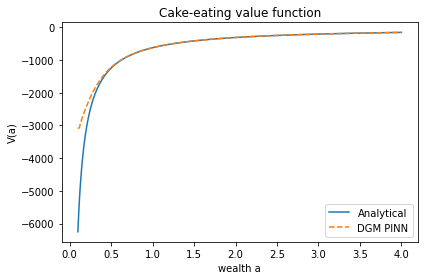

In [8]:
"""
Cake-eating HJB  ·  Deep-Galerkin Method (PyTorch, float64 throughout)
---------------------------------------------------------------------
ρ V(a) = max_c { u(c) + V_a (r a − c) },    u(c)=c^(1−γ)/(1−γ) ,  γ>1

Analytical benchmark
    κ = (ρ − (1−γ)r) / γ   (κ>0)
    V*(a) = κ^(−γ)/(1−γ) · a^(1−γ)
    c*(a) = κ · a

The network outputs V̂(a).  Residual:
    R(a) = ρV̂ − [ u(ĉ) + V̂_a (r a − ĉ) ]
with  ĉ = V̂_a^(−1/γ)  (safe-guarded by softplus).
"""

# -------------------- 1. imports & reproducibility ---------------------------
import torch, torch.nn as nn, torch.autograd as autograd
import numpy as np, matplotlib.pyplot as plt, random, os

SEED = 1234
np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE  = torch.float64

# -------------------- 2. economic parameters ---------------------------------
gamma, rho, r = 2.0, 0.05, 0.03
kappa = (rho - (1-gamma)*r) / gamma
assert kappa > 0, "Choose parameters such that κ>0"

a_min, a_max = 0.1, 4.0                          # training domain
V_star = lambda a: (kappa**-gamma)/(1-gamma) * a**(1-gamma)

# -------------------- 3. DGM network -----------------------------------------
class DGMNet(nn.Module):
    def __init__(self, dim, layers=4, units=64):
        super().__init__()
        self.input = nn.Linear(dim, units)
        self.z  = nn.ModuleList(nn.Linear(dim, units) for _ in range(layers))
        self.g  = nn.ModuleList(nn.Linear(dim, units) for _ in range(layers))
        self.r  = nn.ModuleList(nn.Linear(dim, units) for _ in range(layers))
        self.h  = nn.ModuleList(nn.Linear(dim, units) for _ in range(layers))
        self.wz = nn.ModuleList(nn.Linear(units, units) for _ in range(layers))
        self.wg = nn.ModuleList(nn.Linear(units, units) for _ in range(layers))
        self.wr = nn.ModuleList(nn.Linear(units, units) for _ in range(layers))
        self.wh = nn.ModuleList(nn.Linear(units, units) for _ in range(layers))
        self.out = nn.Linear(units, 1)
        self.act = torch.tanh

    def forward(self, x):                        # x: [batch,1]
        s = self.act(self.input(x))
        for ℓ in range(len(self.z)):
            z = self.act(self.z[ℓ](x) + self.wz[ℓ](s))
            g = self.act(self.g[ℓ](x) + self.wg[ℓ](s))
            r = self.act(self.r[ℓ](x) + self.wr[ℓ](s))
            h = self.act(self.h[ℓ](x) + self.wh[ℓ](s * r))
            s = (1.0 - g) * h + z * s
        return self.out(s).squeeze(-1)           # [batch]

# instantiate in 64-bit
net = DGMNet(dim=1).to(device).double()

# -------------------- 4. PDE residual ----------------------------------------
def pde_residual(model, a):                     # a: [batch,1]
    a.requires_grad_(True)
    V      = model(a)                           # [batch]
    V_a    = autograd.grad(V.sum(), a, create_graph=True)[0].squeeze(-1)

    safe_Va = torch.nn.functional.softplus(V_a) + 1e-6
    c       = safe_Va.pow(-1.0 / gamma)
    u_c     = c.pow(1-gamma) / (1-gamma)

    R = rho*V - (u_c + safe_Va*(r*a.squeeze(-1) - c))
    return R

# -------------------- 5. training set-up -------------------------------------
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[4000, 8000],
                                                 gamma=0.3)

iters      = 12000
batch_sz   = 1024
w_int, w_bnd = 10.0, 1.0

def sample_interior(n):
    return torch.empty(n, 1, device=device, dtype=DTYPE).uniform_(a_min, a_max)

a_bnd = torch.tensor([[a_min],[a_max]], dtype=DTYPE, device=device)

# -------------------- 6. training loop ---------------------------------------
for it in range(1, iters + 1):
    a_int = sample_interior(batch_sz)
    R_int = pde_residual(net, a_int)
    L_int = (R_int**2).mean()

    V_b   = net(a_bnd)
    V_true= torch.tensor(V_star(a_bnd.cpu().numpy()), dtype=DTYPE,
                         device=device).squeeze(-1)
    L_bnd = ((V_b - V_true)**2).mean()

    loss  = w_int*L_int + w_bnd*L_bnd

    opt.zero_grad()
    loss.backward()
    opt.step(); scheduler.step()

    if it % 1000 == 0:
        print(f"iter {it:5d} | loss {loss.item():.3e} "
              f"| int {L_int.item():.1e} | bnd {L_bnd.item():.1e}")

# -------------------- 7. evaluation ------------------------------------------
net.eval()
with torch.no_grad():
    a_test = torch.linspace(a_min, a_max, 400, dtype=DTYPE,
                            device=device).unsqueeze(-1)
    V_hat  = net(a_test).cpu().numpy().ravel()
    V_true = V_star(a_test.cpu().numpy()).ravel()
    mse    = np.mean((V_hat - V_true)**2)
    print(f"\nGrid MSE (DGM vs closed form) : {mse:.3e}")

# -------------------- 8. plot -------------------------------------------------
plt.plot(a_test.cpu(), V_true, label='Analytical')
plt.plot(a_test.cpu(), V_hat , '--', label='DGM PINN')
plt.xlabel('wealth a'); plt.ylabel('V(a)')
plt.title('Cake-eating value function'); plt.legend(); plt.tight_layout(); plt.show()
